In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import k_means
import warnings
from PIL import Image
from io import BytesIO
import requests
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer


warnings.filterwarnings('ignore')

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
df = pd.read_csv('/content/drive/MyDrive/mobile_recommendation_system_dataset.csv')
df.head()

,name,ratings,price,imgURL,corpus
0,"REDMI Note 12 Pro 5G (Onyx Black, 128 GB)",4.2,23999,https://rukminim2.flixcart.com/image/312/312/x...,Storage128 GBRAM6 SystemAndroid 12Processor T...
1,"OPPO F11 Pro (Aurora Green, 128 GB)",4.5,"₹20,999",https://rukminim2.flixcart.com/image/312/312/k...,Storage128 GBRAM6 GBExpandable Storage256GB S...
2,"REDMI Note 11 (Starburst White, 64 GB)",4.2,13149,https://rukminim2.flixcart.com/image/312/312/x...,Storage64 GBRAM4 SystemAndroid 11Processor Sp...
3,"OnePlus Nord CE 5G (Blue Void, 256 GB)",4.1,21999,https://rukminim2.flixcart.com/image/312/312/x...,Storage256 GBRAM12 SystemAndroid Q 11Processo...
4,"APPLE iPhone 13 mini (Blue, 128 GB)",4.6,3537,https://rukminim2.flixcart.com/image/312/312/k...,Storage128 SystemiOS 15Processor TypeA15 Bion...


In [33]:
df.shape

(2546, 5)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2546 entries, 0 to 2545
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   name     2546 non-null   object 
 1   ratings  2546 non-null   float64
 2   price    2546 non-null   object 
 3   imgURL   2546 non-null   object 
 4   corpus   2534 non-null   object 
dtypes: float64(1), object(4)
memory usage: 99.6+ KB


In [35]:
df.isnull().sum()

,0
name,0
ratings,0
price,0
imgURL,0
corpus,12


In [36]:
df.dropna(inplace = True)
df.isnull().sum()

,0
name,0
ratings,0
price,0
imgURL,0
corpus,0


In [37]:
df.shape

(2534, 5)

In [38]:
max_rating = df['ratings'].max()
min_rating = df['ratings'].min()
print('Ratings range: ', (min_rating, max_rating))

Ratings range:  (2.9, 5.0)


In [39]:
df['price'] = df['price'].replace({'₹': '', ',': ''}, regex=True).astype(float)
print(df['price'].dtype)


float64


In [40]:
df.describe(include = 'all')

,name,ratings,price,imgURL,corpus
count,2534,2534.000000,2534.000000,2534,2534
unique,2128,NaN,NaN,1665,1603
top,"OPPO Reno10 5G (Ice Blue, 256 GB)",NaN,NaN,https://rukminim2.flixcart.com/image/312/312/x...,Storage256 GBRAM8 SystemAndroid 13Processor T...
freq,14,NaN,NaN,14,8
mean,NaN,4.296251,16974.611681,NaN,NaN
std,NaN,0.214859,8605.435236,NaN,NaN
min,NaN,2.900000,73.000000,NaN,NaN
25%,NaN,4.200000,10499.000000,NaN,NaN
50%,NaN,4.300000,15499.000000,NaN,NaN
75%,NaN,4.400000,23463.000000,NaN,NaN


[]

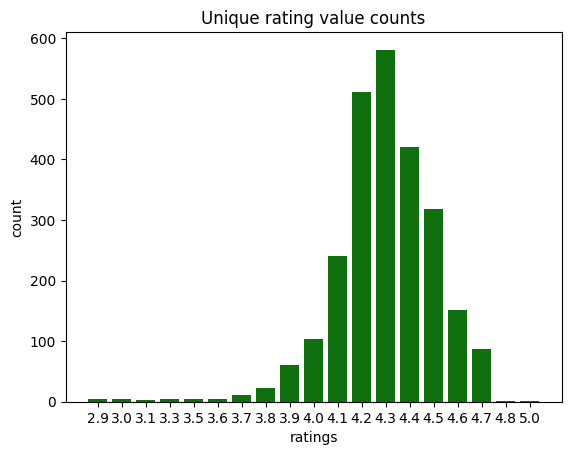

In [41]:
plt.title('Unique rating value counts')
sns.countplot(data = df, x = 'ratings', color = 'green')
plt.plot()

<Axes: xlabel='ratings', ylabel='price'>

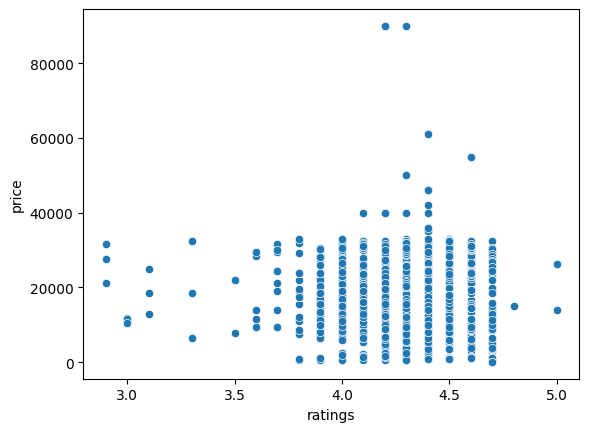

In [42]:
sns.scatterplot(data = df, x = 'ratings', y = 'price')

(-0.5, 238.5, 311.5, -0.5)

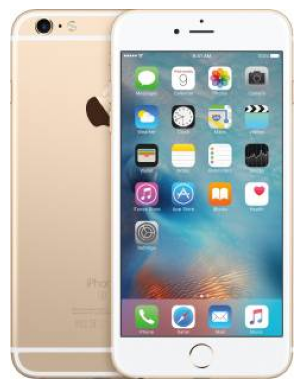

In [43]:
response = requests.get(df['imgURL'][5])
image_data = BytesIO(response.content)

image = Image.open(image_data)

plt.imshow(image)
plt.axis('off')

In [44]:
ratings_summary = df.groupby('name')['ratings'].agg(average_rating='mean', count_rating='count').reset_index()
df = df.merge(ratings_summary, on='name', how='left')
df.head(2)

,name,ratings,price,imgURL,corpus,average_rating,count_rating
0,"REDMI Note 12 Pro 5G (Onyx Black, 128 GB)",4.2,23999.0,https://rukminim2.flixcart.com/image/312/312/x...,Storage128 GBRAM6 SystemAndroid 12Processor T...,4.2,1
1,"OPPO F11 Pro (Aurora Green, 128 GB)",4.5,20999.0,https://rukminim2.flixcart.com/image/312/312/k...,Storage128 GBRAM6 GBExpandable Storage256GB S...,4.5,1


In [45]:
df.shape

(2534, 7)

In [46]:
df.drop_duplicates(subset='name', keep='first', inplace = True)
df.shape

(2128, 7)

In [47]:
nlp = spacy.load("en_core_web_sm")

scaler = StandardScaler()
price_scaled = scaler.fit_transform(df[['price']])
average_rating_scaled = scaler.fit_transform(df[['average_rating']])

def preprocess_text(text):
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(tokens)

df['processed_corpus'] = df['corpus'].apply(preprocess_text)

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['processed_corpus'])

combined_features = hstack([tfidf_matrix, price_scaled, average_rating_scaled])

In [48]:
# from sklearn.cluster import KMeans
# n_clusters = df.shape[0] // 10
# kmeans = KMeans(n_clusters=n_clusters, random_state=42)
# df['cluster'] = kmeans.fit_predict(combined_features)

In [49]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
inertia = []
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(combined_features)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(combined_features, kmeans.labels_))

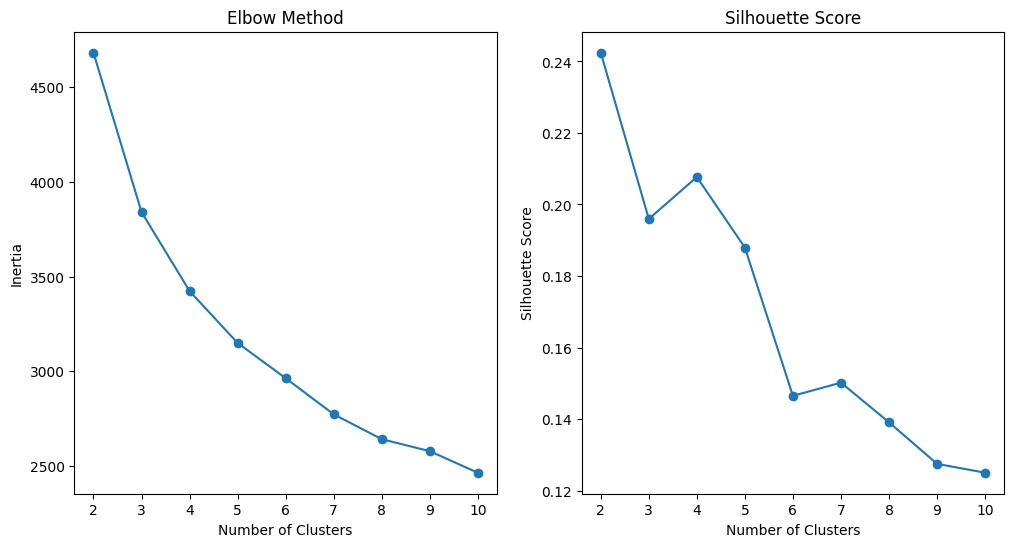

In [50]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.show()

In [51]:
from sklearn.cluster import KMeans
n_clusters = df.shape[0] // 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(combined_features)

In [52]:
df.shape[0] // 10

212

In [53]:
def recommend_products(product_name):
    matching_rows = df[df['name'] == product_name]

    if matching_rows.empty:
        print(f"Product '{product_name}' not found in the dataset.")
        return pd.DataFrame()  # Return an empty DataFrame if not found

    target_cluster = matching_rows['cluster'].values[0]
    recommendations = df[df['cluster'] == target_cluster]
    return recommendations[['name', 'ratings', 'price', 'average_rating', 'imgURL']]


In [54]:
product_name = input('Enter the name of the product: ')
recommendations = recommend_products(product_name)

if not recommendations.empty:
    print(f"Recommendations for {product_name}:")
    print(recommendations)
else:
    print("No recommendations found.")


Enter the name of the product: REDMI Note 12 Pro 5G (Onyx Black, 128 GB)
Recommendations for REDMI Note 12 Pro 5G (Onyx Black, 128 GB):
                                                name  ratings    price  \
0          REDMI Note 12 Pro 5G (Onyx Black, 128 GB)      4.2  23999.0   
68    REDMI Note 12 Pro 5G (Stardust Purple, 128 GB)      4.2  23999.0   
303      REDMI Note 12 Pro 5G (Glacier Blue, 128 GB)      4.2  23999.0   
457        REDMI Note 12 Pro 5G (Onyx Black, 256 GB)      4.2  26999.0   
569     REDMI Note 12 Pro+ 5G (Arctic White, 256 GB)      4.2  29999.0   
1027  REDMI Note 12 Pro 5G (Stardust Purple, 256 GB)      4.2  26999.0   
1540    REDMI Note 12 Pro+ 5G (Iceberg Blue, 256 GB)      4.2  32537.0   
1735     REDMI Note 12 Pro 5G (Glacier Blue, 256 GB)      4.2  26999.0   

      average_rating                                             imgURL  
0                4.2  https://rukminim2.flixcart.com/image/312/312/x...  
68               4.2  https://rukminim2.flixcart.

In [55]:
def visualize_mobile(recommend, total):
    num_columns = 2
    num_rows = (total + 1) // num_columns  # Calculate rows needed, rounding up

    plt.figure(figsize=(10, num_rows * 5))  # Adjust figure size as needed
    for i in range(total):
        plt.subplot(num_rows, num_columns, i + 1)
        response = requests.get(recommendations['imgURL'][i])
        image_data = BytesIO(response.content)
        image = Image.open(image_data)
        plt.imshow(image)
        plt.axis('off')  # Optional: Turn off axis for a cleaner look

    plt.tight_layout()  # Adjust spacing between images
    plt.show()

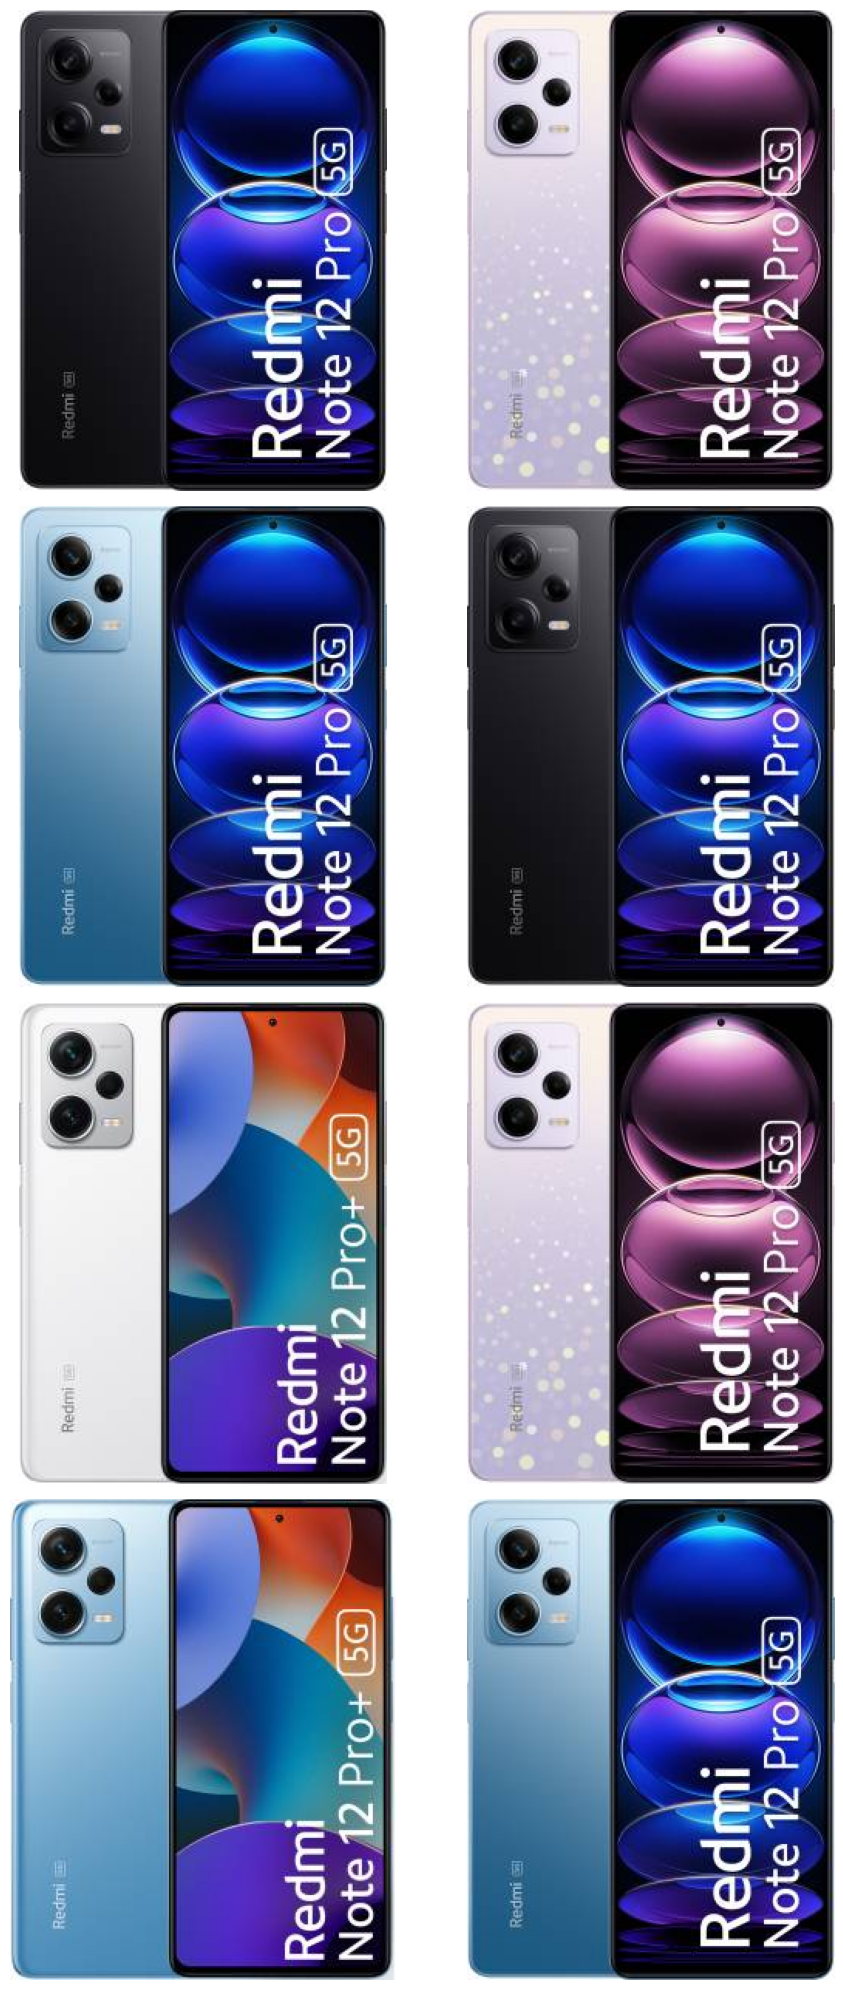

In [56]:
visualize_mobile(recommendations.reset_index(drop = True, inplace  =True), total = recommendations.shape[0])

Inertia for k=212: 1104.8488237583913
Silhouette Score for k=212: 0.20789079268125257


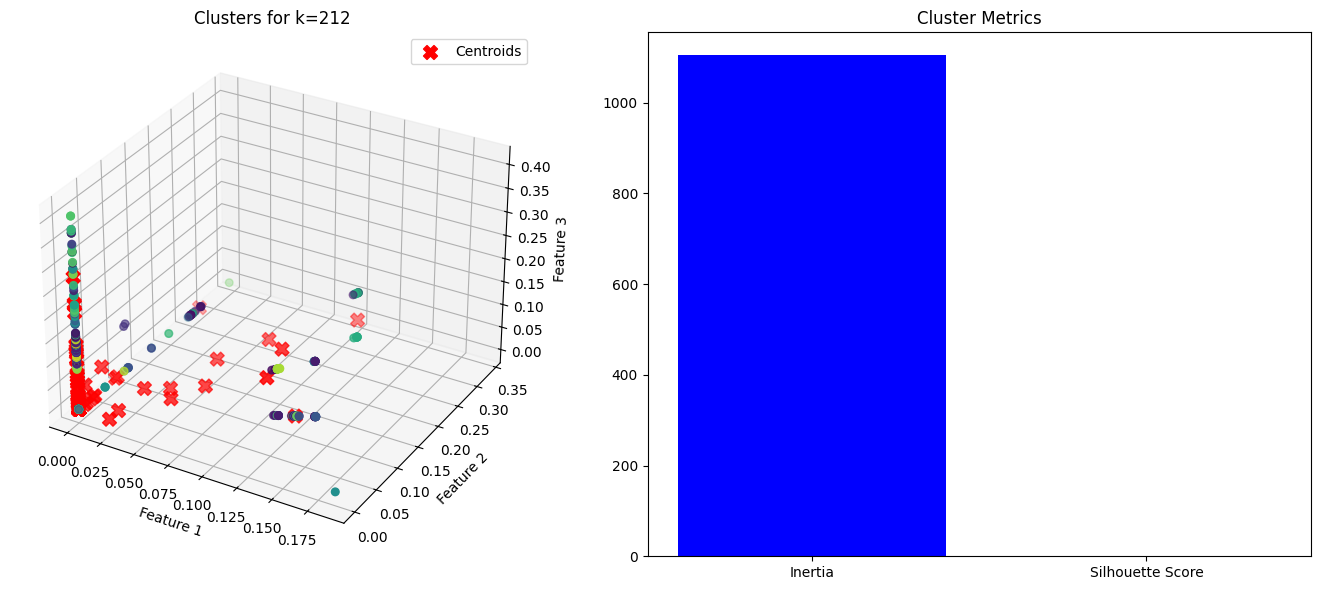

In [57]:
inertia = kmeans.inertia_
k = df.shape[0] // 10

# Calculate silhouette score
silhouette_avg = silhouette_score(combined_features, kmeans.labels_)

combined_features = combined_features.toarray()
# Print values
print(f"Inertia for k={k}: {inertia}")
print(f"Silhouette Score for k={k}: {silhouette_avg}")

# Visualization
fig = plt.figure(figsize=(14, 6))

# 3D Scatter plot of clusters
ax1 = fig.add_subplot(121, projection='3d')
scatter = ax1.scatter(
    combined_features[:, 0], combined_features[:, 1], combined_features[:, 2],
    c=kmeans.labels_, cmap='viridis', s=30
)
ax1.scatter(
    kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2],
    c='red', s=100, marker='X', label="Centroids"
)
ax1.set_title(f"Clusters for k={k}")
ax1.set_xlabel("Feature 1")
ax1.set_ylabel("Feature 2")
ax1.set_zlabel("Feature 3")
ax1.legend()

# Bar plot for inertia and silhouette score
ax2 = fig.add_subplot(122)
metrics = ['Inertia', 'Silhouette Score']
values = [inertia, silhouette_avg]
ax2.bar(metrics, values, color=['blue', 'green'])
ax2.set_title("Cluster Metrics")
ax2.set_ylim(0, max(values) + 50)

plt.tight_layout()
plt.show()